In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

## Load trees from results directory

In [2]:
results = glob.glob("../nextflow/results/*")[-1]
results

'../nextflow/results/2022-04-01'

In [3]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


## Data frame with a row for each edge on each tree, excluding 10-week mice

In [4]:
rows = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if (not node.is_root()) and (node.abundance > 1 or not node.is_leaf()):
            delta_delta_bind = node.delta_bind - node.up.delta_bind
            delta_delta_expr = node.delta_expr - node.up.delta_expr
            rows.append([gc, node.name, node.abundance, node.LBI, node.LBR, delta_delta_bind, delta_delta_expr])
df = pd.DataFrame(rows, columns=["GC", "name", "abundance", "LBI", "LBR", r"parent edge $\Delta$ affinity", r"parent edge $\Delta$ expression"])

# no 10-week
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

df

,GC,name,abundance,LBI,LBR,parent edge $\Delta$ affinity,parent edge $\Delta$ expression
0,mouse1_GC1,seq56,1,5.252151,0.223615,-0.80796,-0.15104
1,mouse1_GC1,25,0,3.107390,1.669774,-7.71074,-0.77924
2,mouse1_GC1,2,0,18.789397,3.377441,0.33100,-0.00561
3,mouse1_GC1,seq14,1,4.452909,0.306784,0.48625,-0.00569
4,mouse1_GC1,36,0,3.257721,1.457129,0.84154,-0.03483
...,...,...,...,...,...,...,...
1738,mouse6_GC77,seq51,2,3.424837,0.058842,0.00000,0.00000
1739,mouse6_GC77,35,0,4.901709,0.606158,-0.01297,-0.10773
1740,mouse6_GC77,seq3,2,1.203368,0.187875,-1.19916,-0.24044
1741,mouse6_GC77,seq37,3,2.629712,0.535954,-0.10438,-0.04884


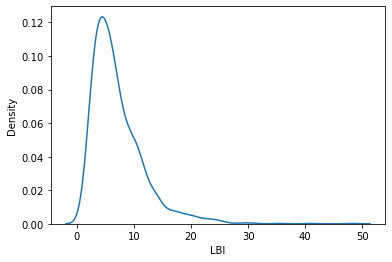

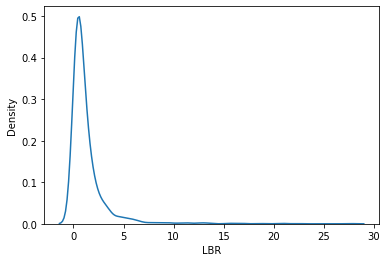

In [5]:
sns.kdeplot(data=df, x="LBI")
plt.show()

sns.kdeplot(data=df, x="LBR")
plt.show()

In [6]:
thresh = 2
df[f"LBR $\geq$ {thresh}"] = df.LBR >= thresh

df = df.sort_values("LBR")

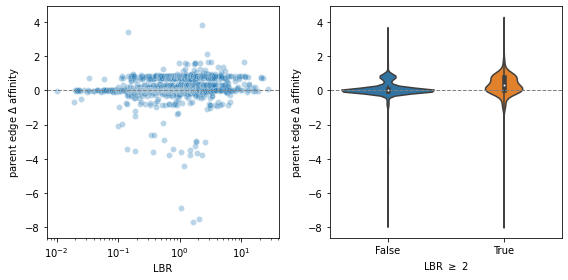

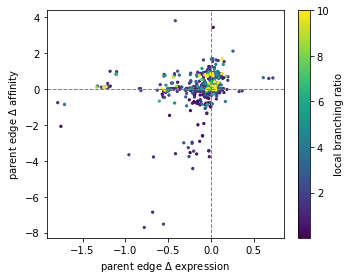

In [7]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
g = sns.scatterplot(data=df, y=r"parent edge $\Delta$ affinity", x="LBR", alpha=0.3)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.xscale("log")

plt.subplot(122, sharey=g)
sns.violinplot(data=df, y=r"parent edge $\Delta$ affinity", x=f"LBR $\geq$ {thresh}")
plt.axhline(0, c="grey", ls="--", lw=1)

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.LBR_Vs_bind.pdf")
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(x=df[r"parent edge $\Delta$ expression"], y=df[r"parent edge $\Delta$ affinity"],
            c=df["LBR"],
            s=5,
            vmax=10,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.ylabel(r"parent edge $\Delta$ affinity")
plt.xlabel(r"parent edge $\Delta$ expression")
plt.colorbar(label="local branching ratio")

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.scatter.pdf")
plt.show()